## Getting the Dataset
Let's try to build a Dog vs Cat Classifier, with limited images. 

There are about 30 training images and 10 validation images for each class. Let us see if we can get a decent accuracy on this [dataset](https://drive.google.com/file/d/1qXKSt6jAgh20f-2PkRT-Z61PW-3E4S_z/edit).



In [ ]:
# Mounting the google drive
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Downloading the dataset

!cp -r drive/My\ Drive/Colab\ Notebooks/ML201+/ML201+/Day\ 3/* . # Change this to the directory of your zip file
!unzip data.zip

cp: cannot open 'drive/My Drive/Colab Notebooks/ML201+/ML201+/Day 3/Day 3.gslides' for reading: Operation not supported
Archive:  data.zip
   creating: data/
   creating: data/train/
   creating: data/train/cat/
  inflating: data/train/cat/11.jpeg  
  inflating: data/train/cat/25.jpeg  
  inflating: data/train/cat/5.jpeg   
  inflating: data/train/cat/16.jpeg  
  inflating: data/train/cat/17.jpeg  
  inflating: data/train/cat/10.jpg   
  inflating: data/train/cat/9.jpg    
  inflating: data/train/cat/6.jpeg   
  inflating: data/train/cat/7.jpeg   
  inflating: data/train/cat/12.jpeg  
  inflating: data/train/cat/8.jpeg   
  inflating: data/train/cat/13.jpeg  
  inflating: data/train/cat/14.jpeg  
  inflating: data/train/cat/18.jpeg  
  inflating: data/train/cat/15.jpeg  
  inflating: data/train/cat/19.jpeg  
  inflating: data/train/cat/20.jpeg  
  inflating: data/train/cat/21.jpeg  
  inflating: data/train/cat/22.jpeg  
  inflating: data/train/cat/23.jpeg  
  inflating: data/train/cat/

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

## Data augmentation

Normally, since the data we have is small, we would carry out data augmentation on the dataset.

In [ ]:
# Data augmentation and normalization for training and validation
# Just Normalization for validation
data_transforms = {
    'train': transforms.Compose([    
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), # Standard values for normalization based on ImageNet Dataset


    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data' # Change this to the directory that your folder is stored

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']} # Stores into data loaders

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes # Get class names

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualise the images

Let us visualise the images to understand these data augmentations

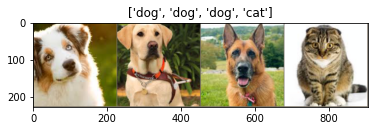

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the Model

Here is a general function to train the model. It also allows us to save the best model to allow us to run some visualisation tasks later on.

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualising model predictions

Here is a function to display predictions for some images.

In [ ]:
def visualize_model(model, num_images=6): # Changes number of images to be displayed
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Transfer Learning: An Overview (2 methods)

For image classification, there are many pre-trained models out there which are trained with millions of images. Click [here](https://pytorch.org/docs/stable/torchvision/models.html) to check out the different pre-trained models pytorch offers on images.

It would be good if we can simply just extract the weights from these trained models and apply it for our own use. (Saves us ALOT of time!!) This is where transfer learning comes into play. There are 2 main approaches to transfer learning:

### 1) Fine-Tuning: 
All layers of model will be optimized and "fine-tuned" during training based on the specific classification task.

### 2) Feature Extraction from the Convnet:
Freeze the bottom few layers, leaving only the last few layers unfrozen. Only the weights of the newly added last layers would change during the training phase.

## Transfer Learning 1: Fine-tuning the Convnet

We will use a load a pre-trained resnet34 model, and reset the final fully connected layer.

In [ ]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2, because we are classifying 2 classes, cats and dogs.
# A more general form is as such: nn.Linear(num_ftrs, len(class_names))
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device) # Makes use of GPU

criterion = nn.CrossEntropyLoss()

# Observe that all parameters throughout all layers are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5184 Acc: 0.7333
val Loss: 0.0601 Acc: 1.0000

Epoch 1/9
----------
train Loss: 0.3455 Acc: 0.8667
val Loss: 0.0148 Acc: 1.0000

Epoch 2/9
----------
train Loss: 0.3548 Acc: 0.8500
val Loss: 0.0138 Acc: 1.0000

Epoch 3/9
----------
train Loss: 0.3446 Acc: 0.8500
val Loss: 0.0501 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.6708 Acc: 0.8167
val Loss: 0.0317 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.4241 Acc: 0.8167
val Loss: 0.0040 Acc: 1.0000

Epoch 6/9
----------
train Loss: 0.0471 Acc: 0.9833
val Loss: 0.0026 Acc: 1.0000

Epoch 7/9
----------
train Loss: 0.1351 Acc: 0.9667
val Loss: 0.0018 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.3007 Acc: 0.8667
val Loss: 0.0041 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.4693 Acc: 0.8500
val Loss: 0.0240 Acc: 1.0000

Training complete in 0m 13s
Best val Acc: 1.000000


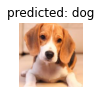

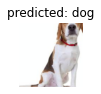

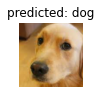

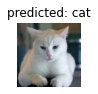

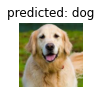

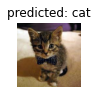

In [ ]:
# visualize predicted images
visualize_model(model_ft)

## Transfer Learning 2: Feature Extraction of ConvNet

Here, we freeze all the network except the final layer. We set the `requires_grad == False` to freeze the parameters so that the gradients are not computed in `backward()`.

In [ ]:
model_conv = models.resnet34(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that ONLY parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In resnet18, the last layer is a fully-connected layer with 1000 neurons (1000 classes). Since our classification problem is a binary one, we will need to alter the final layer to have 2 neurons.

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5696 Acc: 0.6833
val Loss: 0.2056 Acc: 1.0000

Epoch 1/9
----------
train Loss: 0.3260 Acc: 0.8000
val Loss: 0.0850 Acc: 1.0000

Epoch 2/9
----------
train Loss: 0.2989 Acc: 0.8833
val Loss: 0.0599 Acc: 1.0000

Epoch 3/9
----------
train Loss: 0.1102 Acc: 0.9833
val Loss: 0.0359 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.1978 Acc: 0.9000
val Loss: 0.0435 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.4799 Acc: 0.7833
val Loss: 0.0320 Acc: 1.0000

Epoch 6/9
----------
train Loss: 0.2239 Acc: 0.9167
val Loss: 0.0350 Acc: 1.0000

Epoch 7/9
----------
train Loss: 0.1825 Acc: 0.9333
val Loss: 0.0210 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.0620 Acc: 0.9833
val Loss: 0.0151 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.0707 Acc: 0.9667
val Loss: 0.0166 Acc: 1.0000

Training complete in 0m 10s
Best val Acc: 1.000000


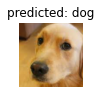

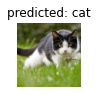

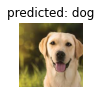

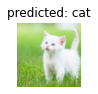

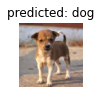

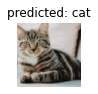

In [ ]:
visualize_model(model_conv)

**Quick question:**

Why is the validation loss 1.0?

## A Final Note on Transfer Learning

So when do we use fine-tuning/feature extraction for transfer learning??

Depends on various factors, but more important ones to look at are the size of the NEW dataset, and the similarity of the NEW dataset to the original dataset.
Keep in mind that DCNN features are more generic in early layers and more dataset-specific in later layers.

**4 Scenarios:**

1. Small dataset and similar in context to original dataset

If the data is small, it is not a good idea to fine-tune the DCNN due to overfitting concerns. Since the data is similar to the original data, we expect higher-level features in the DCNN to be relevant to this dataset as well. Hence, the best idea might be to **train a linear classifier on the CNN-features in the last few layers.**

2. Large dataset and similar in context to original dataset (BEST CASE)

Since we have more data, we can have more confidence that we would not overfit if we were to try to **fine-tune through the entire network.**

3. Small dataset and different in context to original dataset (WORSE CASE)

Since the data is small, it is likely best to only train a linear classifier. Since the dataset is very different, it might not be best to train the classifier from the top of the network, which contains more dataset-specific features. Instead, it might work better to **train a classifier from activations somewhere earlier in the network.**

4. Large dataset and different in context to original dataset

Since the dataset is very large, we may expect that we can afford to train a DCNN from scratch. However, in practice it is very often still beneficial to initialize with weights from a pre-trained model. In this case, we would have enough data and confidence to **fine-tune through the entire network.**

## Discriminative Learning Rates

Change the learning rates of different layers of the model created during training. This can be done by changing the optimizer function.

In [ ]:
# code is same as above, just changed the optimizer part

model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2, because we are classifying 2 classes, cats and dogs.
# A more general form is as such: nn.Linear(num_ftrs, len(class_names))
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device) # Makes use of GPU

criterion = nn.CrossEntropyLoss()

# Change the optimizer part of the code, select the layer that you want to change learning rate of.
opt = optim.SGD([
{"params": model_ft.layer1.parameters(), "lr": 1e-2}, # Set a dictionary to change the layer of learning rate that you require
{"params": model_ft.fc.parameters(), "lr": 1e-3}
], lr=1e-2, momentum=0.9)



ResNet34 documentation can be found [here](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py). (To get the names of the layers)

Other parameters that are didn't specify in optimizer will not optimize. So you should state all layers or groups (OR the layers you want to optimize). If you didn't specify the learning rate it will take the global learning rate(1e-2) in this case.

The trick here is when you create the model you should give names to the layers, and then call these layers whenever you want to set the learning rate. For instance, model_ft.layer1 calls layer1 of the resnet architecture to alter the learning rate.

In [ ]:
model_ft = train_model(model_ft, criterion, opt,
                       num_epochs=10)


Epoch 0/9
----------
train Loss: 0.6499 Acc: 0.6333
val Loss: 0.1429 Acc: 1.0000

Epoch 1/9
----------
train Loss: 0.1477 Acc: 0.9833
val Loss: 0.0318 Acc: 1.0000

Epoch 2/9
----------
train Loss: 0.1845 Acc: 0.9500
val Loss: 0.0266 Acc: 1.0000

Epoch 3/9
----------
train Loss: 0.2113 Acc: 0.8833
val Loss: 0.0217 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.0720 Acc: 1.0000
val Loss: 0.0128 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.1946 Acc: 0.9333
val Loss: 0.0244 Acc: 1.0000

Epoch 6/9
----------
train Loss: 0.2557 Acc: 0.9167
val Loss: 0.0185 Acc: 1.0000

Epoch 7/9
----------
train Loss: 0.0557 Acc: 1.0000
val Loss: 0.0171 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.0411 Acc: 1.0000
val Loss: 0.0114 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.1825 Acc: 0.9000
val Loss: 0.0109 Acc: 1.0000

Training complete in 0m 12s
Best val Acc: 1.000000
